<center>
    <h1>Transfer Learning and Fine-tuning Convolutional Neural Networks</h1>
</center>

# Introduction to Transfer Learning

Transfer learning is a machine learning technique where a model developed for one task is reused as the starting point for a model on a second task. In the context of deep learning and CNNs, transfer learning is particularly powerful because:

1. Lower layers of CNNs learn generic features (edges, textures, patterns) that are useful across many vision tasks
2. Training deep networks from scratch requires massive amounts of data and computational resources
3. Pre-trained models capture rich feature representations learned from large datasets like ImageNet

## Why Transfer Learning?

- **Reduced Training Time**: Starting with pre-trained weights significantly reduces the time needed to train a model
- **Less Data Required**: Can achieve good performance even with smaller datasets
- **Better Generalization**: Pre-trained models often provide better generalization capabilities
- **Resource Efficient**: Requires less computational power compared to training from scratch

## Types of Transfer Learning

### 1. Feature Extraction
- Freeze the pre-trained network's weights
- Remove the last few layers
- Add new layers for your specific task
- Only train the new layers

### 2. Fine-tuning
- Start with a pre-trained network
- Unfreeze some or all layers
- Continue training with a very small learning rate
- Allows the model to adapt to your specific task

## Popular Pre-trained Models

Some commonly used pre-trained models include:
- VGG16/VGG19
- ResNet50
- InceptionV3
- MobileNet
- EfficientNet

# Implementing Transfer Learning and Fine-tuning with CIFAR-10 Dataset

The CIFAR-10 dataset consists of 60,000 32x32 color images divided into 10 classes, making it perfect for learning transfer learning concepts. Let's build a model that can classify these images using transfer learning techniques.

## 1. Setting Up the Environment

First, let's import our required libraries and set up our environment with proper seeding for reproducibility:

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
import random
import os
import gc

# Set seeds for reproducibility
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Configure GPU memory growth if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Set seeds
set_seeds()

## 2. Loading and Preparing the Dataset

We'll use the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes:

In [2]:
# Load the dataset
(train_ds, test_ds), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# Print dataset information
num_classes = ds_info.features['label'].num_classes
print(f"Number of training examples: {ds_info.splits['train'].num_examples}")
print(f"Number of test examples: {ds_info.splits['test'].num_examples}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {ds_info.features['label'].names}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.HBRPOI_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.HBRPOI_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Number of training examples: 50000
Number of test examples: 10000
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3. Data Preprocessing and Augmentation

Let's define our preprocessing and augmentation functions with memory optimization in mind:

In [3]:
# Constants for image processing
BATCH_SIZE = 16  # Small batch size for memory efficiency
IMG_SIZE = 96    # Input size for MobileNetV2

def preprocess_data(image, label):
    """Preprocess a single image and its label"""
    # Normalize and resize image
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    # Convert label to one-hot encoding
    label = tf.one_hot(label, num_classes)
    return image, label

# Memory-efficient data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
], name='data_augmentation')

def prepare_dataset(dataset, is_training=False):
    """Prepare dataset with memory optimization"""
    AUTOTUNE = tf.data.AUTOTUNE

    # Basic preprocessing
    dataset = dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)

    if is_training:
        # Shuffle with small buffer
        dataset = dataset.shuffle(1000)
        # Apply augmentation
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    # Batch and prefetch
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Prepare our datasets
train_ds = prepare_dataset(train_ds, is_training=True)
test_ds = prepare_dataset(test_ds)

## 4. Creating the Model

We'll create a memory-efficient model using MobileNetV2 as our base:

In [4]:
def create_model(trainable=False):
    """Create a memory-efficient transfer learning model"""
    # Base model
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = trainable

    # Create simplified model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create initial model for feature extraction
initial_model = create_model(trainable=False)
initial_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
initial_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 5. Training Functions

Let's define our training function with callbacks for monitoring and early stopping:

In [7]:
def train_model(model, epochs, model_name="model"):
    """Train model with memory-efficient settings"""
    callbacks = [
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        # Reduce learning rate when plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2
        ),
        # Save weights checkpoint with correct file extension
        tf.keras.callbacks.ModelCheckpoint(
            f'best_{model_name}.weights.h5',  # Changed extension to .weights.h5
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True
        )
    ]

    history = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=epochs,
        callbacks=callbacks
    )

    return history

## 6. Feature Extraction Phase

First, let's train the model with frozen base layers:

In [8]:
# Try running the training again
print("Starting feature extraction phase...")
feature_history = train_model(
    initial_model,
    epochs=5,
    model_name="feature_extraction"
)

# Clear memory
gc.collect()

Starting feature extraction phase...
Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 121s 36ms/step - accuracy: 0.5459 - loss: 1.3220 - val_accuracy: 0.7534 - val_loss: 0.7294 - learning_rate: 0.0010
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 123s 31ms/step - accuracy: 0.6518 - loss: 1.0142 - val_accuracy: 0.7404 - val_loss: 0.8019 - learning_rate: 0.0010
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 98s 31ms/step - accuracy: 0.6581 - loss: 1.0067 - val_accuracy: 0.7442 - val_loss: 0.7562 - learning_rate: 0.0010
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 143s 32ms/step - accuracy: 0.6780 - loss: 0.9354 - val_accuracy: 0.7702 - val_loss: 0.6648 - learning_rate: 2.0000e-04
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 142s 32ms/step - accuracy: 0.6865 - loss: 0.9072 - val_accuracy: 0.7732 - val_loss: 0.6596 - learning_rate: 2.0000e-04


237

## 7. Fine-tuning Phase

Now, let's fine-tune the model by unfreezing some layers:

In [12]:
print("Starting fine-tuning phase...")
fine_tune_model = create_model(trainable=True)

# Modify freezing strategy:
# Since validation metrics are consistently better than training,
# we can be more aggressive with unfreezing layers
for layer in fine_tune_model.layers[0].layers[:-40]:  # Unfreeze more layers
    layer.trainable = False

# Adjust learning rate and compile
fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=5e-5  # Slightly higher learning rate
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Increase epochs since the model shows stable learning
fine_tune_history = train_model(
    fine_tune_model,
    epochs=8,  # Increased from 5 to 8
    model_name="fine_tuning"
)

# Clear memory
gc.collect()

Starting fine-tuning phase...
Epoch 1/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 133s 38ms/step - accuracy: 0.5632 - loss: 1.2975 - val_accuracy: 0.8142 - val_loss: 0.5550 - learning_rate: 5.0000e-05
Epoch 2/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 131s 36ms/step - accuracy: 0.7459 - loss: 0.7442 - val_accuracy: 0.8452 - val_loss: 0.4660 - learning_rate: 5.0000e-05
Epoch 3/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 141s 36ms/step - accuracy: 0.7825 - loss: 0.6312 - val_accuracy: 0.8461 - val_loss: 0.4650 - learning_rate: 5.0000e-05
Epoch 4/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 142s 36ms/step - accuracy: 0.8022 - loss: 0.5709 - val_accuracy: 0.8690 - val_loss: 0.3920 - learning_rate: 5.0000e-05
Epoch 5/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 112s 36ms/step - accuracy: 0.8250 - loss: 0.5105 - val_accuracy: 0.8574 - val_loss: 0.4235 - learning_rate: 5.0000e-05
Epoch 6/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 142s 36ms/step - accuracy: 0.8376 - loss: 0.4702 - val_accuracy: 0.8677 - val_loss: 0.4097 - learning_rate: 5.0000e-05
Epoch 7/8


15649

## 8. Visualizing Results

Let's create functions to visualize our training results:

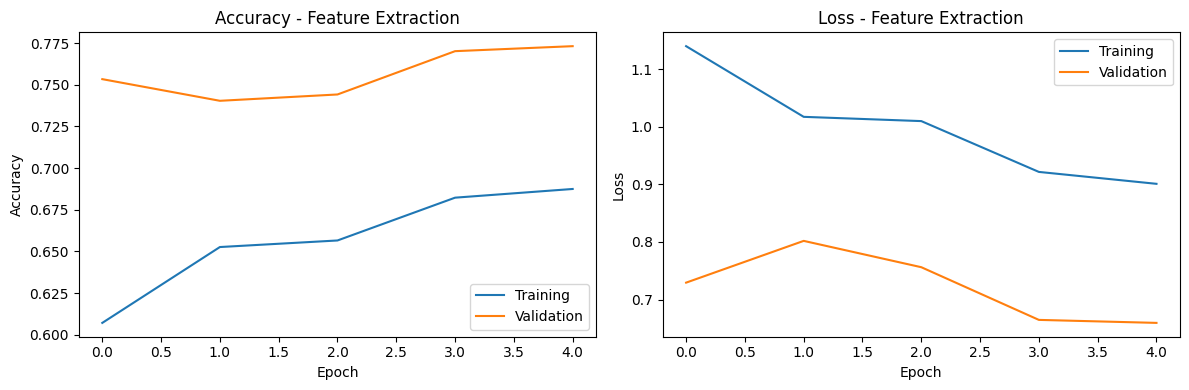

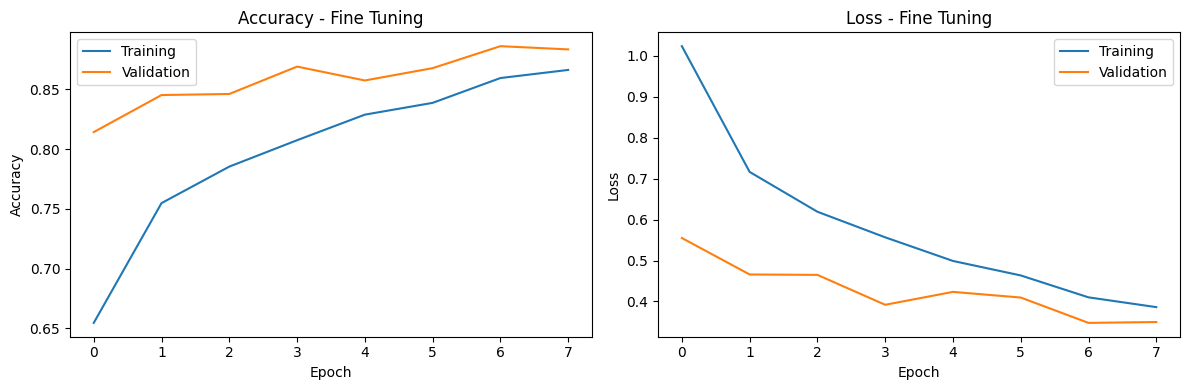

In [13]:
def plot_training_history(history, title=''):
    """Plot training history"""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'Accuracy - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'Loss - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot results
plot_training_history(feature_history, 'Feature Extraction')
plot_training_history(fine_tune_history, 'Fine Tuning')

## 9. Making Predictions

Finally, let's create a function to make predictions on new images:

In [ ]:
def predict_image(model, image_path):
    """Predict class for a single image"""
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=(IMG_SIZE, IMG_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = ds_info.features['label'].names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    return predicted_class, confidence

# Example usage:
predicted_class, confidence = predict_image(fine_tune_model, 'static/image2.jpg')
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: bird
Confidence: 0.99


## Best Practices for Transfer Learning

1. **Dataset Considerations**:
   - Ensure your dataset is similar to the original dataset used for pre-training
   - Use data augmentation for small datasets
   - Maintain proper train/validation/test splits

2. **Model Selection**:
   - Choose a pre-trained model that matches your computational resources
   - Consider the trade-off between model size and accuracy
   - Look for models trained on similar domains to your task

3. **Training Strategy**:
   - Start with feature extraction before fine-tuning
   - Use a small learning rate when fine-tuning
   - Monitor validation metrics to prevent overfitting
   - Implement early stopping and learning rate scheduling

## Common Challenges and Solutions

1. **Overfitting**:
   - Solution: Increase dropout rate, add more data augmentation, reduce model complexity

2. **Training Instability**:
   - Solution: Reduce learning rate, use gradient clipping, implement proper batch normalization

3. **Memory Issues**:
   - Solution: Reduce batch size, use mixed precision training, choose a smaller base model

## Conclusion

Transfer learning is a powerful technique that allows us to leverage pre-trained models for new tasks. Key takeaways:

- Transfer learning significantly reduces training time and data requirements
- Fine-tuning can improve performance on specific tasks
- Proper training strategy and hyperparameter selection is crucial
- Regular monitoring and evaluation help prevent overfitting